# Amadeus v1 - Music Genre Classification

## Import Libraries and Data

In [2]:
from keras import models, layers
import librosa 
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import random
import sklearn
import csv
import keras
import pandas as pd
import tensorflow as tf
from tensorflow.python.framework import ops
import h5py

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [3]:
raw_data = np.genfromtxt('database.csv', delimiter=',', dtype=None, encoding='UTF8')

## Load Example Genre

Genres:
* Classical
* Country
* Disco
* Hiphop
* Jazz
* Rock
* Blues
* Reggae
* Pop
* Metal

In [4]:
genre = 'Classical'

mapping = {
    'Classical': 0,
    'Country': 100,
    'Disco': 200,
    'Hiphop': 300,
    'Jazz': 400,
    'Rock': 500,
    'Blues': 600,
    'Reggae': 700,
    'Pop': 800,
    'Metal': 900
}

index = random.randint(mapping[genre], mapping[genre]+99)
print(genre, ":", index)
    
ex = raw_data[index][0]
data, sr = librosa.load(ex, mono=True, duration=30)
ipd.Audio(ex)

Classical : 40


## Extract Mel-Spectogram from Example

In the previous model, I used a standard neural network after extracting audio signal features for the input. However, for this model, I will be using a CNN with the mel-spectograms of the audio clips.

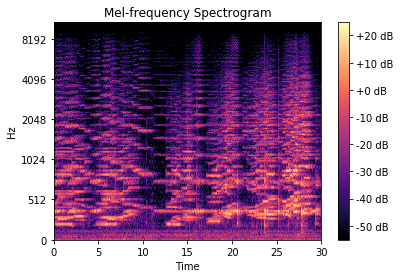

In [5]:
S = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=512)
S_dB = librosa.power_to_db(S)
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency Spectrogram')
plt.show()

## Create Mel-Spectogram Dataset from Song Database (Run Once)

In [6]:
# Split dataset into 80% for training and 20% for testing.
# This just needs to be run once to create the .h5 files.
print("Create mel-spectogram dataset from song database. This might take a while.")
num_songs = 1000

X = np.empty([1000, 512, 1290])
Y = np.zeros([1000, 1])

# Outdated...
# encoding = {
#     0: 'Classical',
#     1: 'Country',
#     2: 'Disco',
#     3: 'Hiphop',
#     4: 'Jazz',
#     5: 'Rock',
#     6: 'Blues',
#     7: 'Reggae',
#     8: 'Pop',
#     9: 'Metal'
# }

for i in range(0, num_songs):
    ex = raw_data[i][0]
    data, sr = librosa.load(ex, mono=True, duration=30)

    # Not all songs are 30 seconds exact. So we have to trim to the shortest song in the GTZAN dataset.
    data = data[:660000]
    
    S = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=512)
    S_dB = librosa.power_to_db(S)

    X[i] = S_dB
    Y[i] = i//100

    if i % 100 == 99:
        print("Finished", str((i//100+1)*10)+'%', 'of music feature extraction for dataset.')

Create mel-spectogram dataset from song database. This might take a while.
Finished 10% of music feature extraction for dataset.
Finished 20% of music feature extraction for dataset.
Finished 30% of music feature extraction for dataset.
Finished 40% of music feature extraction for dataset.
Finished 50% of music feature extraction for dataset.
Finished 60% of music feature extraction for dataset.
Finished 70% of music feature extraction for dataset.
Finished 80% of music feature extraction for dataset.
Finished 90% of music feature extraction for dataset.
Finished 100% of music feature extraction for dataset.


In [7]:
X_file = h5py.File('data/X_data.h5', 'w')
X_file.create_dataset('X', data=X)
X_file.close()

Y_file = h5py.File('data/Y_data.h5', 'w')
Y_file.create_dataset('Y', data=Y, dtype='int')
Y_file.close()

## Load Mel-Spectogram Dataset

In [6]:
split = 900

X_file = h5py.File('data/X_data.h5', 'r')
X_train_raw = X_file['X'][:split]
X_test_raw = X_file['X'][split:]
X_file.close()

Y_file = h5py.File('data/Y_data.h5', 'r')
Y_train_raw = Y_file['Y'][:split]
Y_test_raw = Y_file['Y'][split:]
Y_file.close()

In [7]:
def one_hot_encoding(Y, total):
    encoded = np.eye(total)[Y.reshape(-1)]
    return encoded

In [8]:
Y_train = one_hot_encoding(Y_train_raw, 10)
Y_test = one_hot_encoding(Y_test_raw, 10)

In [9]:
X_train = X_train_raw[..., np.newaxis]
X_test = X_test_raw[..., np.newaxis]

In [10]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(900, 512, 1290, 1)
(900, 10)
(100, 512, 1290, 1)
(100, 10)


## Create Tensorflow Model

In [11]:
def forward_propogation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    W4 = parameters['W4']
    
    Z1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    Z3 = tf.nn.conv2d(P2, W3, strides=[1, 1, 1, 1], padding='SAME')
    A3 = tf.nn.relu(Z3)
    P3 = tf.nn.max_pool(A3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    Z4 = tf.nn.conv2d(P3, W4, strides=[1, 1, 1, 1], padding='SAME')
    A4 = tf.nn.relu(Z4)
    P4 = tf.nn.max_pool(A4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    F = tf.contrib.layers.flatten(P4)

    Z5 = tf.contrib.layers.fully_connected(F, 512, activation_fn=tf.nn.relu)
    
    Z6 = tf.contrib.layers.fully_connected(Z5, 10, activation_fn=None)

    return Z6

In [12]:
def compute_cost(Z, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z, labels=Y))
    return cost

In [13]:
def random_minibatches(X, Y, minibatch_size):
    m = X.shape[0]
    minibatches = []
    
    permutation = list(np.random.permutation(m))
    X_shuffled = X[permutation, :, :, :]
    Y_shuffled = Y[permutation, :]
    
    for i in range(m//minibatch_size):
        X_minibatch = X_shuffled[i*minibatch_size:(i+1)*minibatch_size, :, :, :]
        Y_minibatch = Y_shuffled[i*minibatch_size:(i+1)*minibatch_size, :]
        minibatches.append((X_minibatch, Y_minibatch))
    
    if m % minibatch_size != 0:
        X_minibatch = X_shuffled[i*minibatch_size:m, :, :, :]
        Y_minibatch = Y_shuffled[i*minibatch_size:m, :]
        minibatches.append((X_minibatch, Y_minibatch))
    
    return minibatches

In [14]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.005, num_epochs=100, minibatch_size=64, print_cost=True):
    """
    Implements a CNN in tensorflow.
    """
    ops.reset_default_graph()
    (m, H, W, _) = X_train.shape
    n = Y_train.shape[1]
    costs = []
    
    X = tf.placeholder(tf.float32, [minibatch_size, H, W, 1])
    Y = tf.placeholder(tf.float32, [minibatch_size, n])
    
    W1 = tf.get_variable('W1', [3, 3, 1, 16], initializer=tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable('W2', [3, 3, 16, 32], initializer=tf.contrib.layers.xavier_initializer())
    W3 = tf.get_variable('W3', [3, 3, 32, 64], initializer=tf.contrib.layers.xavier_initializer())
    W4 = tf.get_variable('W4', [3, 3, 64, 128], initializer=tf.contrib.layers.xavier_initializer())
    parameters = { 'W1': W1, 'W2': W2, 'W3': W3, 'W4': W4 }
    
    Z = forward_propogation(X, parameters)
    cost = compute_cost(Z, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            minibatch_cost = 0
            num_minibatches = m//minibatch_size
            minibatches = random_minibatches(X_train, Y_train, minibatch_size)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run(fetches=[optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                minibatch_cost += temp_cost/num_minibatches
            
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
    
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    predict_op = tf.argmax(Z3, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
    
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print(accuracy)
    train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
    test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)

    return train_accuracy, test_accuracy, parameters

In [ ]:
model(X_train, Y_train, X_test, Y_test)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

